Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [1]:
!pip install tf-nightly -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
assert tf.__version__== '2.5.0-dev20201111','bad version'

2.5.0-dev20201111


In [2]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
#print(now())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done, mounted


In [3]:
cd /content/drive/My Drive/BC-MRI-AE/

/content/drive/My Drive/BC-MRI-AE


In [4]:
cd 'Colab Notebooks'

/content/drive/My Drive/BC-MRI-AE/Colab Notebooks


In [5]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:00.648837


In [6]:
cd ../

/content/drive/My Drive/BC-MRI-AE


SHAPE THE DATA

In [7]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [8]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [9]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=1)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,ID,SUB_TYPE,VISIT,DAY_LAG,ABIDE_01,ABIDE_02,ABIDE_03,ABIDE_04,ABIDE_05,ABIDE_06,ABIDE_07,ABIDE_08,ABIDE_9,ABIDE_10,ABIDE_11,ABIDE_12,ABIDE_13,ABIDE_14,ABIDE_15,ABIDE_16,ABIDE_17,ABIDE_18,ABIDE_19,ABIDE_20,ABIDE_21,ABIDE_22,ABIDE_23,ABIDE_24,ABIDE_25,ABIDE_26,ABIDE_27,ABIDE_28,ABIDE_29,ABIDE_30,ABIDE_31,ABIDE_32,ABIDE_33,ABIDE_34,ABIDE_35,ABIDE_36,ABIDE_37,ABIDE_38,ABIDE_39,ABIDE_40,ABIDE_41,ABIDE_42,ABIDE_43,ABIDE_44,ABIDE_45,ABIDE_46,ABIDE_47,ABIDE_48,ABIDE_49,ABIDE_50,ABIDE_51,ABIDE_52,ABIDE_53,ABIDE_54,ABIDE_55,ABIDE_56,ABIDE_57,ABIDE_58,ABIDE_59,ABIDE_60,ABIDE_61,ABIDE_62,ABIDE_63,ABIDE_64,ABIDE_65,ABIDE_66,ABIDE_67,ABIDE_68,ABIDE_69,ABIDE_70,ABIDE_71,ABIDE_72,ABIDE_73
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,1,110.0,NaN,NaN,WST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,1,119.0,NaN,NaN,WST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,1,133.0,NaN,NaN,WST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,1,122.0,NaN,NaN,WST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,1,114.0,NaN,NaN,WST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [10]:
TD_subs = ABIDE_data[np.array(df['SUB_TYPE']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['SUB_TYPE']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [11]:
dxArr = np.ones(len(df))
dxArr[np.array(df['SUB_TYPE']=='PATIENT')]=2

In [12]:
batch_size = 32

TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]

TRAIN THE VAE

In [13]:
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)
vae.load_weights('../tf_outputs/weights/lol')

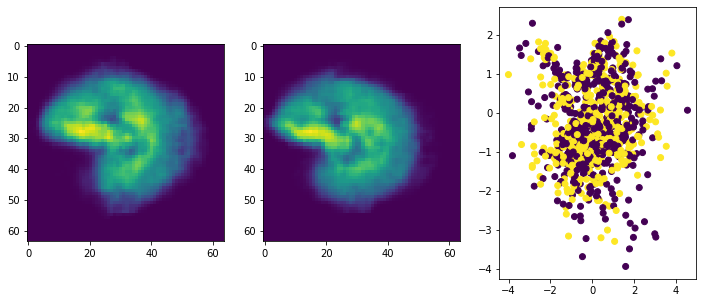

In [32]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(vae.predict(TD_batch)[0,32,:,:,0])
plt.subplot(1,3,2)
plt.imshow(decoder.predict(np.random.randn(3,2))[0,32,:,:,0])
plt.subplot(1,3,3)
arr = encoder.predict(ABIDE_data)[2]
plt.scatter(arr[:,0],arr[:,1],c=dxArr)

In [15]:
#encoder.save

TRAIN THE CONTRASTIVE VAE

In [16]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D()
cvae.load_weights('../tf_outputs/3D_CCVAE_Weights/lol')

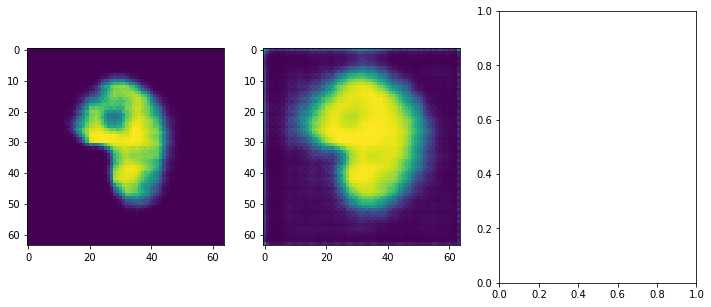

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(cvae.predict([TD_batch,DX_batch])[0][0,32,:,:,0])
plt.subplot(1,3,2)
plt.imshow(cvae_decoder.predict(np.random.randn(3,4))[0,32,:,:,0])
plt.subplot(1,3,3)

In [18]:
# for i in range(100):
#   cvae.fit([DX_batch,TD_batch],epochs=10)
#   cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/lol')

In [19]:
# cvae.fit([DX_batch,TD_batch],epochs=1000)
# cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/lol')

In [20]:
# cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_celeb_cvae(input_shape=(width, height, 3), latent_dim=latent_dim, bias=True, disentangle=True, gamma=1)

# for i in tqdm(range(10000)):
#   #DX_subs,TD_subs
#   #cvae.train_on_batch([DX_subs[np.random.randint(0,DX_subs.shape[0],batch_size),:,:,:],TD_subs[np.random.randint(0,TD_subs.shape[0],batch_size),:,:,:]])
#   cvae.train_on_batch([TD_subs[np.random.randint(0,TD_subs.shape[0],batch_size),:,:,:],DX_subs[np.random.randint(0,DX_subs.shape[0],batch_size),:,:,:]])

In [21]:
# plt.figure(figsize=(12,8))
# for i in range(4):
#   plt.subplot(1,4,i+1)
#   plt.imshow(ABIDE_data_3d[np.random.randint(1,high=ABIDE_data_3d.shape[0]),:,:,0])
#   plt.xticks([]);plt.yticks([])

# plt.figure(figsize=(12,8))
# for i in range(16):
#   plt.subplot(4,4,i+1)
#   plt.imshow(cvae_decoder.predict(np.random.randn(1,4))[0,:,:,0])
#   plt.xticks([]);plt.yticks([])

In [22]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# z_mean, z_log_var, z = z_encoder(ABIDE_data_3d[:,:,:,:])
# x = z
# plt.scatter(x[:,0],x[:,1],c=dxArr)
# plt.title('background')

# plt.subplot(1,3,2)
# s_mean, s_log_var, s = s_encoder(ABIDE_data_3d[:,:,:,:])
# x = s
# plt.scatter(x[:,0],x[:,1],c=dxArr)
# plt.title('salient')

# plt.subplot(1,3,3)
# v_mean, v_log_var, v = encoder(ABIDE_data_3d[:,:,:,:])
# x = v
# plt.scatter(x[:,0],x[:,1],c=dxArr)
# plt.title('v')

# plt.figure(figsize=(6,4))
# plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)])
# plt.xticks([0,1,2],labels=['background','salient','vae'])

In [23]:
# from scipy.spatial.distance import pdist
# from scipy.spatial.distance import squareform

# arr = [ABIDE_data_3d[s,:,:,:].flatten() for s in range(ABIDE_data_3d.shape[0])]
# arr = np.array(arr)

In [24]:

# arrs = (np.corrcoef(arr),1-squareform(pdist(v)),1-squareform(pdist(z)),1-squareform(pdist(s)))
# ttls = ['anatomy','VAE','Background','Salient']
# plt.figure(figsize=(16,12))
# for i in range(4):
#   plt.subplot(2,2,i+1)
#   sns.heatmap(arrs[i])
#   plt.title(ttls[i])

In [25]:
# Get avg e dist between ASD and TD
# What is the 258 on the bottlenack

In [26]:
# s_encoder.summary()